In [2]:
from ase.db import connect
from ase.cluster import Icosahedron
from ase.constraints import FixAtoms
from ase.calculators.emt import EMT
import numpy as np
from nn_optimize import Ensemble_Relaxer
from ase.optimize import BFGS
from matplotlib import pyplot as plt
import os
from ase.calculators.singlepoint import SinglePointCalculator as SPC
from ase.io.trajectory import Trajectory

### Create demo nanoparticles

In [3]:
db = connect('./AuPd-ico-to-relax-10.db')

if db.count() == 0:
    atoms = Icosahedron('Au', noshells=3, latticeconstant=4.0)
    elements = ['Au', 'Pd']
    nrgs = [] 
    configs = []

    while len(nrgs) < 10:
        symbols = np.random.choice(elements, size=len(atoms), replace=True)
        dummy = atoms.copy()
        dummy.center(vacuum=7.0)
        dummy.set_chemical_symbols(symbols)
        dummy.set_calculator(EMT())
        cnst = FixAtoms(range(13))
        dummy.set_constraint(cnst)
        nrg = dummy.get_potential_energy()
        if nrg not in nrgs:
            nrgs.append(nrg)
            configs.append(dummy)

    for atoms in configs:
        atoms.rattle(0.1)

    for config in configs:
        db.write(config)


### NN ensemble relaxer
 - Run NN relaxer like ASE optimzer
 - Need to provide a ASE calculator into the relaxer class, assume the relaxation job runs locally
 - The neural network training and atoms relxation run sequentially, since have no idea about users' job submit system
 - Preset hyperparameters to train NN and atoms relaxation, like learning rate, NN structure, relaxation max step

In [4]:
nn_params = {'layer_nodes': [40, 40], 'activations': ['tanh', 'tanh'], 'lr': 1}
alpha = 2.0  # confidence coeffience, used to control in what extend we trust the NN model

relaxer = Ensemble_Relaxer(db=db, calculator=EMT(), jobname='AuPd-nano-test', ensemble_size=10, alpha=alpha, nn_params=nn_params)

# relaxer.run() returns a ase-db containing relaxed configurations
relaxed_db = relaxer.run(fmax=0.05, steps=50)

Step 0: get groud truth data
Step 0: groud truth data calculation done
max force for each configuration: 
[2.411, 2.71, 2.411, 2.673, 2.817, 2.713, 2.583, 2.455, 2.356, 2.481]
Step 0: start training
Step 0: training done
Step 0: start NN relaxation
Step 0: NN relaxation done
Step 1: get groud truth data
Step 1: groud truth data calculation done
max force for each configuration: 
[1.227, 1.577, 1.424, 1.481, 1.651, 1.564, 1.674, 1.205, 1.402, 1.547]
Step 1: start training
Step 1: training done
Step 1: start NN relaxation
Step 1: NN relaxation done
Step 2: get groud truth data
Step 2: groud truth data calculation done
max force for each configuration: 
[0.271, 0.351, 0.382, 0.377, 0.44, 0.324, 0.423, 0.316, 0.347, 0.409]
Step 2: start training
Step 2: training done
Step 2: start NN relaxation
Step 2: NN relaxation done
Step 3: get groud truth data
Step 3: groud truth data calculation done
max force for each configuration: 
[0.042, 0.032, 0.029, 0.034, 0.029, 0.025, 0.025, 0.026, 0.028, 0

In [5]:
nn_max_fs = []
for entry in relaxed_db.select():
    atoms = entry.toatoms()
    max_f = np.linalg.norm(atoms.get_forces(), axis=1).max()
    nn_max_fs.append(round(max_f, 3))
print(nn_max_fs)

[0.042, 0.032, 0.029, 0.034, 0.029, 0.025, 0.025, 0.026, 0.028, 0.033]


### BFGS

In [6]:

if not os.path.isdir('AuPd-nano-test/AuPd-nano-BFGS'):
    os.mkdir('AuPd-nano-test/AuPd-nano-BFGS')

c = 0
for entry in db.select():
    atoms = entry.toatoms()
    atoms.set_calculator(EMT())
    c += 1
    dyn = BFGS(atoms, trajectory=f'AuPd-nano-test/AuPd-nano-BFGS/config-{c}.traj')
    dyn.run(0.05, steps=50)

      Step     Time          Energy         fmax
BFGS:    0 15:24:53       27.869531        2.4112
BFGS:    1 15:24:53       26.708430        2.3441
BFGS:    2 15:24:53       25.504086        2.2428
BFGS:    3 15:24:53       24.446528        2.1122
BFGS:    4 15:24:53       23.531230        1.9476
BFGS:    5 15:24:53       22.753227        1.7446
BFGS:    6 15:24:53       22.107332        1.4987
BFGS:    7 15:24:53       21.588275        1.2056
BFGS:    8 15:24:54       21.190668        0.8624
BFGS:    9 15:24:54       20.908383        0.5540
BFGS:   10 15:24:54       20.731154        0.5885
BFGS:   11 15:24:54       20.635867        0.5986
BFGS:   12 15:24:54       20.539094        0.5667
BFGS:   13 15:24:54       20.401223        0.5124
BFGS:   14 15:24:54       20.292433        0.4023
BFGS:   15 15:24:54       20.240039        0.2864
BFGS:   16 15:24:54       20.224447        0.2849
BFGS:   17 15:24:54       20.203704        0.1991
BFGS:   18 15:24:54       20.184493        0.1889
B

In [7]:
def retrive_nn_trajs(init_db, n_steps, fmax):
    init_cnstrt = [entry.toatoms().constraints for entry in init_db.select()]
    config_steps = [[] for _ in range(init_db.count())]
    config_convgs = [False] * init_db.count()

    for i in range(n_steps+1):
        tmp_db = connect(os.path.join('AuPd-nano-test/relax_trajs', f'to-cal-step{i}-gt.db'))
        tmp_configs = [entry.toatoms() for entry in tmp_db.select()]
        tmp_frs = [atoms.get_forces() for atoms in tmp_configs]
        tmp_nrgs = [atoms.get_potential_energy() for atoms in tmp_configs]
        j = 0
        for k, convg in enumerate(config_convgs):
            if not convg:
                f = tmp_frs[j]
                for c in init_cnstrt[k]:
                    c.adjust_forces(None, f)
                mf = np.linalg.norm(f, axis=1).max()
                if mf <= fmax:
                    config_convgs[k] = True
                dummy = tmp_configs[j].copy()
                dummy.set_constraint(init_cnstrt[k])
                dummy.set_calculator(SPC(dummy, energy=tmp_nrgs[j], forces=tmp_frs[j]))
                config_steps[k].append(dummy)
                j += 1

    return config_steps


def retrive_bfgs_trajs():
    config_steps = []
    for i in range(1, 11):
        traj = Trajectory(f'AuPd-nano-test/AuPd-nano-BFGS/config-{i}.traj')
        config_steps.append(list(traj))
    return config_steps

In [8]:
nn_relax_trajs = retrive_nn_trajs(db, 3, 0.05)
bfgs_relax_trajs = retrive_bfgs_trajs()

Text(0, 0.5, 'Max force ($eV/\\AA$)')

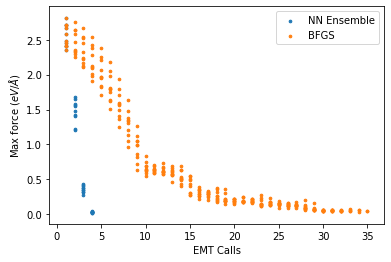

In [9]:
nn_max_frs = []
bfgs_max_frs = []
for traj in nn_relax_trajs:
    config_max_frs = [np.linalg.norm(atoms.get_forces(), axis=1).max() for atoms in traj]
    nn_max_frs.append(config_max_frs)

for traj in bfgs_relax_trajs:
    config_max_frs = [np.linalg.norm(atoms.get_forces(), axis=1).max() for atoms in traj]
    bfgs_max_frs.append(config_max_frs)

fig = plt.figure()
ax = fig.add_subplot(111)
for max_frs in nn_max_frs:
    s1 = ax.scatter(np.arange(len(max_frs)) + 1, max_frs, c='C0', s=7)
for max_frs in bfgs_max_frs:
    s2 = ax.scatter(np.arange(len(max_frs)) + 1, max_frs, c='C1', s=7)
ax.legend([s1, s2], ['NN Ensemble', 'BFGS'])
ax.set_xlabel('EMT Calls')
ax.set_ylabel(r'Max force ($eV/\AA$)')